## Initialization

In [1]:
import numpy as np
import prox_tv as ptv
import time
import scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import utils
import utils_jax
import jax
import jax.numpy as jnp

from args import get_KTR_args
args = get_KTR_args()
# n = args.n
# r = args.r
# SNR_db = args.SNR_db
# image_switch = args.image_switch

n = 1000
r = 2
SNR_db = 20
image_switch = 0
ifsavedata = 0
MCiter = 101
image_list = ['cross', 'gradient', 'floor']
image = image_list[image_switch]

if image == 'cross':
    b = np.zeros((100, 100)) # Draw a black cross in the middle
    b[45:55, 25:75], b[25:75, 45:55] = 1, 1 # Thin, Fat
elif image == 'gradient':
    b = np.repeat(np.linspace(0.4, 1.0, num=100).reshape(1,-1), 100, axis=0)
    b[30:70, 30:70] =  np.repeat(np.linspace(1.0, 0.4, num=40).reshape(1,-1), 40, axis=0)
elif image == 'floor':
    b = np.zeros((100,100))
    b[0:100, 0:50] = np.repeat((np.linspace(1.0, 0.5, num=50).reshape(1,-1))**1.5, 100, axis=0)
    b[0:100, 50:100] = np.repeat((np.linspace(0.5, 1.0, num=50).reshape(1,-1))**1.5, 100, axis=0)

b = jnp.asarray(b) 
p1,p2 = b.shape
print("Size of my image",b.shape)
print('Image: ',image ,', n: ',n, ', rank: ',r,', SNR_db: ', SNR_db)

# Covariate initialization
p0 = 5  # dimension of the regular covariate 
b0 = np.ones((p0,1))
X  = np.random.randn(n,p0) 
M  = np.random.randn(n,p1,p2)
mu = X@b0 +  M.reshape(n,p1*p2)@ b.flatten().reshape(-1,1)
y = utils.AWGN(mu, SNR_db).reshape(-1,1)

''' Check MAXT and LS Speed; Provide best LS initialization for PGA '''
start = time.perf_counter()
beta0,B0_ls,B1_ls,dev,_,nriters = utils_jax.ALS_cg(X,M,y,r, Replicates = 1, MaxIter = 200, verbose=False)
B_ls = B0_ls@B1_ls.T
print('Err', np.linalg.norm(B_ls.flatten() - b.flatten()), "; Jax Elapsed = {}s".format((time.perf_counter() - start)))

Size of my image (100, 100)
Image:  gradient , n:  2000 , rank:  2 , SNR_db:  20
Err 3.805645 ; Jax Elapsed = 1.7830794030005563s


## Load Tuned Parameters

In [2]:
folder = "tuning"
path_LAM = f"%s/LAMs_image%s_rank%s_SNR%s_n%s.npy" % (folder, image_switch, r, SNR_db, n)
lams_set = np.load(path_LAM)
lams_set_fl0fl1 = lams_set[0]
lams_set_fr0fr1 = lams_set[1]
lams_set_fl0fr1 = np.zeros((2, 2))
lams_set_fr0fl1 = np.zeros((2, 2))
lams_set_fl0fr1[0,:] = lams_set_fl0fl1[0,:]
lams_set_fl0fr1[1,:] = lams_set_fr0fr1[1,:]
lams_set_fr0fl1[0,:] = lams_set_fr0fr1[0,:]
lams_set_fr0fl1[1,:] = lams_set_fl0fl1[1,:]

[[ 880.28408411 4000.        ]
 [  20.          880.28408411]]
[[  20.         4000.        ]
 [ 193.72501719 4000.        ]]
[[ 880.28408411 4000.        ]
 [ 193.72501719 4000.        ]]
[[  20.         4000.        ]
 [  20.          880.28408411]]


## Main Algorithms

In [ ]:
alg_tno = 5
maxT_temp = 125

B = np.zeros((p1,p2,alg_tno,MCiter))
Err = np.zeros((alg_tno,MCiter))
''' --- Start the Main Algorithms ---'''
for it in tqdm(range(MCiter)):
    # --- Alg. 0 Least Square ---
    alg_idx = 0
    beta0,B0_ls,B1_ls,dev,_,nriters = utils_jax.ALS_cg(X,M,y,r, Replicates = 10, 
                                                       MaxIter = maxT_temp, verbose=False)
    B_ls = B0_ls@B1_ls.T
    B[...,alg_idx,it] = B_ls
    Err[alg_idx,it] = np.linalg.norm(B[...,alg_idx,it].flatten() - b.flatten())

    # --- Alg. 1 B0:FL B1:FL ---
    alg_idx = 1
    solver_set = [0, 0]
    beta0,B0,B1,dev = utils_jax.KTR(X,M,y,r,lams_set_fl0fl1,solver_set,B0=B0_ls,B1=B1_ls, nonneg = 1, 
                                          MaxIter = maxT_temp, verbose = False)
    B_fl0fl1 = B0@B1.T
    B[...,alg_idx,it] = B_fl0fl1
    Err[alg_idx,it] = np.linalg.norm(B[...,alg_idx,it].flatten() - b.flatten())

    # --- Alg. 2 B0:FL B1:FR ---
    alg_idx = 2
    solver_set = [0, 1]
    beta0,B0,B1,dev = utils_jax.KTR(X,M,y,r,lams_set_fl0fr1,solver_set,B0=B0_ls,B1=B1_ls, nonneg = 1, 
                                          MaxIter = maxT_temp, verbose = False)
    B_fl0fr1 = B0@B1.T
    B[...,alg_idx,it] = B_fl0fr1
    Err[alg_idx,it] = np.linalg.norm(B[...,alg_idx,it].flatten() - b.flatten())
    
    # --- Alg. 3 B0:FR B1:FL ---
    alg_idx = 3
    solver_set = [1, 0]
    beta0,B0,B1,dev = utils_jax.KTR(X,M,y,r,lams_set_fr0fl1,solver_set,B0=B0_ls,B1=B1_ls, nonneg = 1, 
                                          MaxIter = maxT_temp, verbose = False)
    B_fr0fl1 = B0@B1.T
    B[...,alg_idx,it] = B_fr0fl1
    Err[alg_idx,it] = np.linalg.norm(B[...,alg_idx,it].flatten() - b.flatten())

    # --- Alg. 4 B0:FR B1:FR ---
    alg_idx = 4
    solver_set = [1, 1]
    beta0,B0,B1,dev = utils_jax.KTR(X,M,y,r,lams_set_fr0fr1,solver_set,B0=B0_ls,B1=B1_ls, nonneg = 1, 
                                          MaxIter = maxT_temp, verbose = False)
    B_fr0fr1 = B0@B1.T
    B[...,alg_idx,it] = B_fr0fr1
    Err[alg_idx,it] = np.linalg.norm(B[...,alg_idx,it].flatten() - b.flatten())

## Estimation Presentation

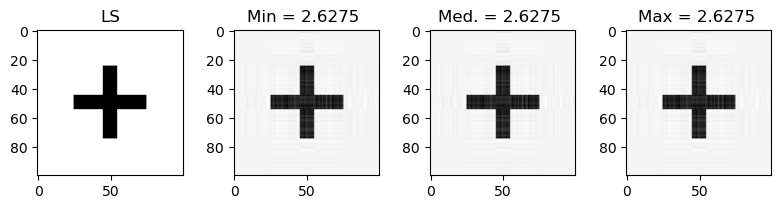

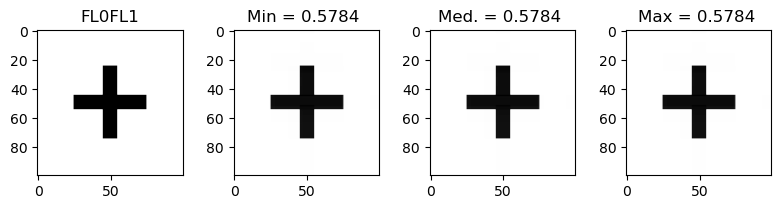

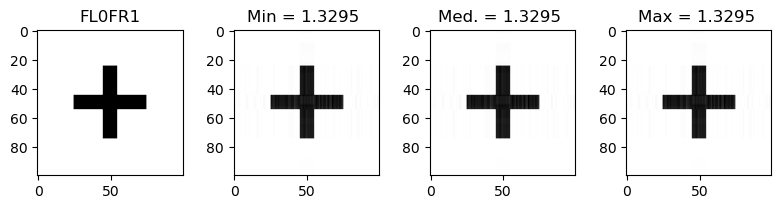

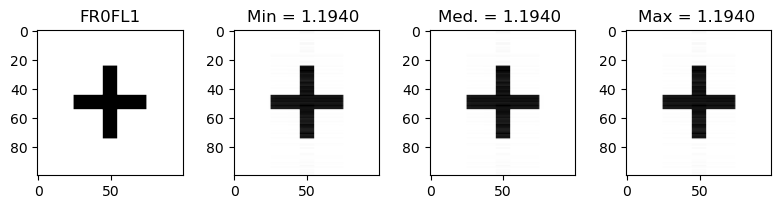

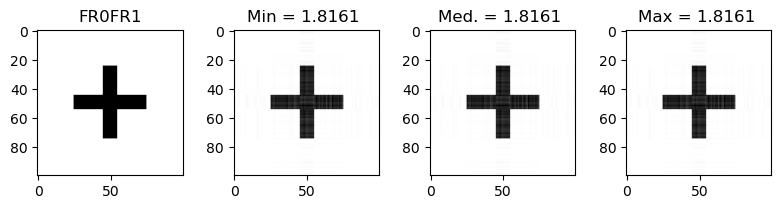

         min Err  med. Err   max Err
LS      2.627485  2.627485  2.627485
FL0FL1  0.578408  0.578408  0.578408
FL0FR1  1.329454  1.329454  1.329454
FR0FL1  1.193977  1.193977  1.193977
FR0FR1  1.816103  1.816103  1.816103
Data is saved


In [ ]:
alg_list = ['LS','FL0FL1','FL0FR1','FR0FL1','FR0FR1']
'''FIGURE DISPLAYING'''
for alg_idx in range(alg_tno):
    
    Err_alg = Err[alg_idx,:]
    med = np.median(Err_alg)
    onevec = np.arange(len(Err_alg)).reshape(-1,1)
    med_idx = int(onevec[Err_alg==med])
    min_idx = np.argmin(Err_alg)
    max_idx = np.argmax(Err_alg)

    fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize = (8,2))
    ax1.imshow(b,cmap='Greys')
    ax1.set_title(alg_list[alg_idx])
    ax2.imshow(B[:,:,alg_idx,min_idx],cmap='Greys')
    ax2.set_title("Min = %.4f " % Err_alg[min_idx]) 
    ax3.imshow(B[:,:,alg_idx,med_idx],cmap='Greys')
    ax3.set_title("Med. = %.4f " % Err_alg[med_idx]) 
    ax4.imshow(B[:,:,alg_idx,max_idx],cmap='Greys')
    ax4.set_title("Max = %.4f " % Err_alg[max_idx]) 
    plt.tight_layout()
    plt.show()

In [ ]:
'''ERROR TABLE DISPLAYING'''
datatable = pd.DataFrame(data=np.hstack((np.min(Err,axis=1).reshape(-1,1),
            np.median(Err,axis=1).reshape(-1,1),
            np.max(Err,axis=1).reshape(-1,1))),
            columns=["min Err","med. Err","max Err"],
            index=alg_list)
print(datatable)

# '''ESTIMATION OUTPUT'''
if ifsavedata == 1:
    folder = "output"
    path_B = f"%s/B_image%s_rank%s_SNR%s_n%s.npy" % (folder, image_switch, r, SNR_db, n)
    path_Err = f"%s/Err_image%s_rank%s_SNR%s_n%s.npy" % (folder, image_switch, r, SNR_db, n)
    np.save(path_B, B)
    np.save(path_Err, Err)
    print('Data is saved')
else:
    print('Data is not saved, this excution is just for testing.')